This is a simulation of the rerouting algorithm. We will be using the PUJ route T307 (Boni - Pinatubo → Stop n' Shop).

In [3]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd

## Prepare Data

### Creating Bounding Box

In [4]:
BOUNDING_BOX = (14.60692, 14.56838, 121.06303, 120.99891) # bounding box as (north, south, east, west)
graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)

/tmp/ipykernel_3866/3675650549.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)


### Plot Area

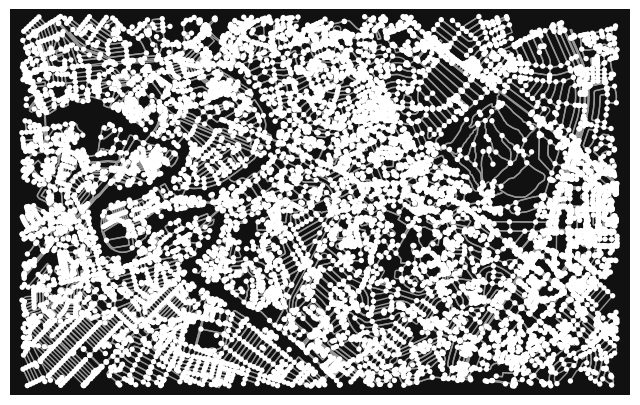

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(graph_of_area)

In [6]:
gdf_edges = ox.graph_to_gdfs(graph_of_area, nodes=False)

In [7]:
gdf_edges.head()

osmid  oneway lanes  ref  \
u        v          key                                                        
12067613 1981388318 0                           264965502    True     4    1   
         962953430  0    [29256184, 188165094, 188165111]    True     2    1   
12067619 6970838871 0                          1254512972    True   NaN  NaN   
         8459730704 0                           671955931    True     2    1   
12067627 8242414108 0                            22598208   False     2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 1981388318 0                     EDSA     trunk       60    False   
         962953430  0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 1981388318 0     15.937    NaN   
         962953430  0    860.735    yes   
12067619 6970838871 0      5.014    NaN   
         8459730704 0    199.554    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 1981388318 0    LINESTRING (121.05548 14.58452, 121.05537 14.5...   
         962953430  0    LINESTRING (121.05548 14.58452, 121.05543 14.5...   
12067619 6970838871 0    LINESTRING (121.05468 14.58309, 121.05464 14.5...   
         8459730704 0    LINESTRING (121.05468 14.58309, 121.05400 14.5...   
12067627 8242414108 0    LINESTRING (121.04673 14.57158, 121.04667 14.5...   

                             access service width junction bridge  
u        v          key                                            
12067613 1981388318 0           NaN     NaN   NaN      NaN    NaN  
         962953430  0           NaN     NaN   NaN      NaN    NaN  
12067619 6970838871 0    permissive     NaN   NaN      NaN    NaN  
         8459730704 0           NaN     NaN   NaN      NaN    NaN  
12067627 8242414108 0           NaN     NaN   NaN      NaN    NaN

In [8]:
gdf_edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
gdf_edges_web_mercator = gdf_edges.to_crs(epsg=3857)

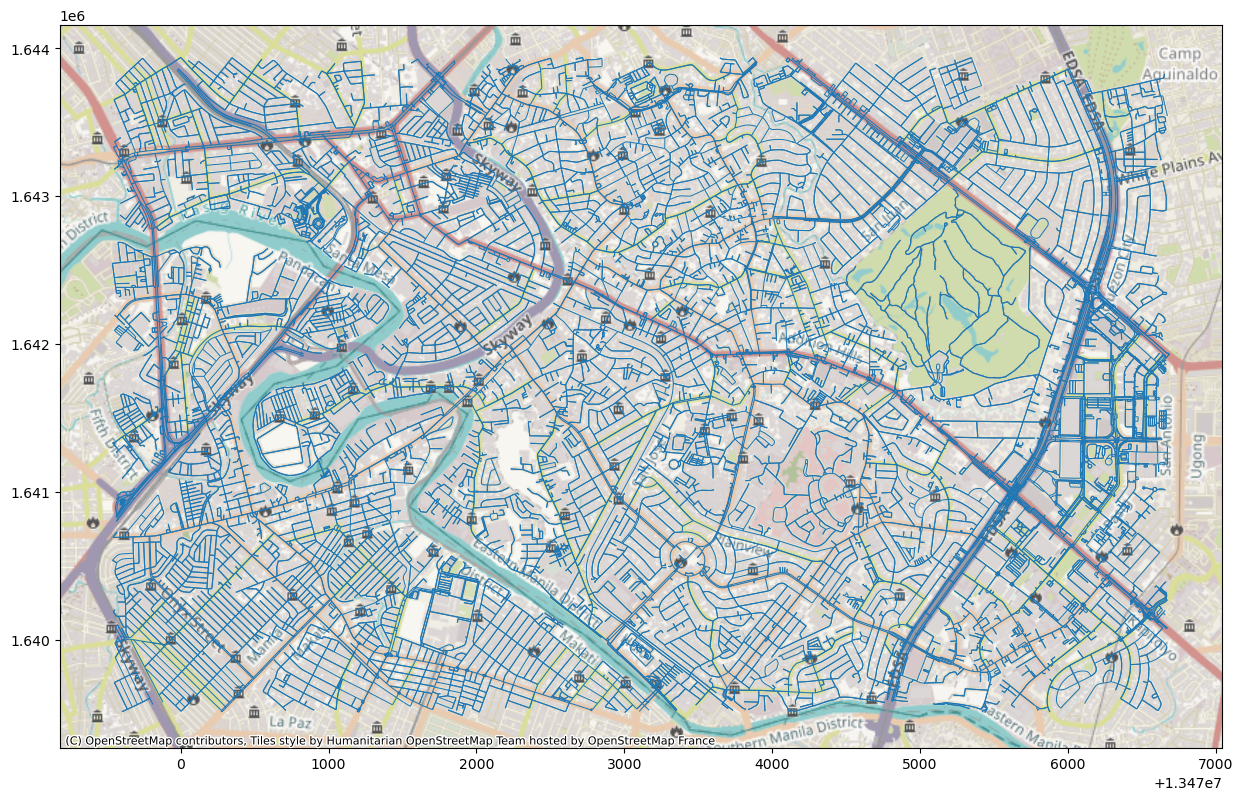

In [10]:
_, ax = plt.subplots(1,1, figsize=(15,15))
gdf_edges_web_mercator.plot(linewidth=.75, ax=ax)
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

In [14]:
import overpass
import json
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import overpy
from osmapi import OsmApi

### Using overpy

In [15]:
# Initialize Overpass API
api = overpy.Overpass()

# Specify the relation ID you want to query
relation_id = 11246072  # Replace with the actual relation ID

In [16]:
# Query to fetch the relation by ID
query = f"""
relation({relation_id});
out body;
"""

# Fetch the relation data
result = api.query(query)

# Check if we got the relation
if len(result.relations) > 0:
    relation = result.relations[0]  # Access the first relation
else:
    print("No relation found.")

In [17]:
node_ids = []
way_ids = []
for member in relation.members:
    if type(member) == overpy.RelationNode:
        node_ids.append(member.ref)
    elif type(member) == overpy.RelationWay:
        way_ids.append(member.ref)

In [18]:
query = f"""
node(id:{','.join(map(str, node_ids))});
out body;
"""
result = api.query(query)
    
def get_nodes():
    for node in result.get_nodes():
        yield Point(node.lon, node.lat)

In [19]:
query = f"""
way(id:{','.join(map(str, way_ids))});
out body;
"""
result = api.query(query)

def get_ways():
    for way in result.get_ways():
        yield LineString(Point(node.lon, node.lat) for node in way.get_nodes(resolve_missing=True)) 

### Create Subgraph

In [32]:
subgraph = graph_of_area.subgraph(result.get_node_ids())

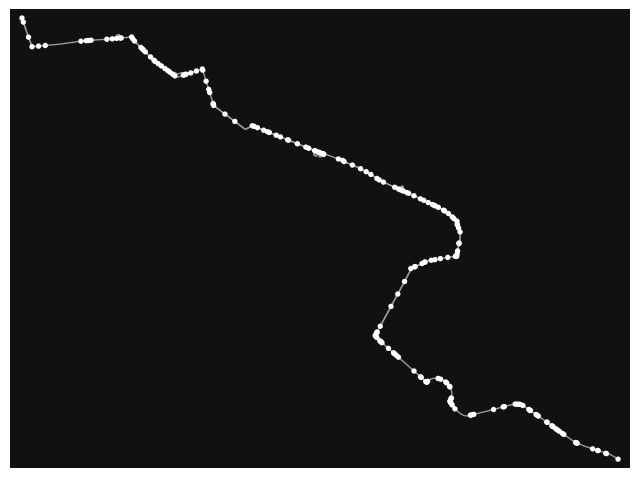

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
ox.plot_graph(subgraph)

### Plotting Route

In [153]:
# Create a GeoDataFrame for ways
gdf_way_points = gpd.GeoSeries(pd.Series(get_ways()), crs="EPSG:4326") # WGS84

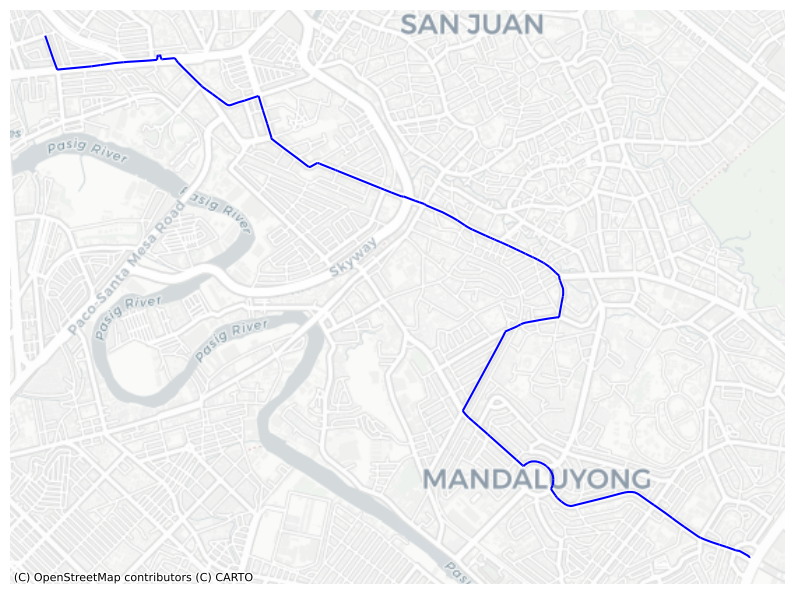

In [154]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_ways_wm = gdf_way_points.to_crs(epsg=3857)
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Plotting nodes.

In [145]:
# Create a GeoDataFrame for ways
gdf_node_points = gpd.GeoSeries(pd.Series(get_nodes()), crs="EPSG:4326")  # WGS84

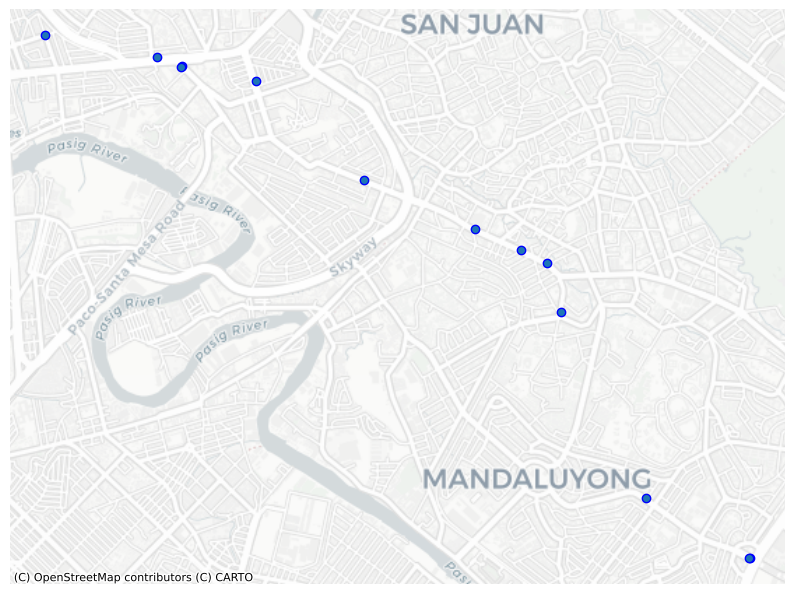

In [146]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm = gdf_node_points.to_crs(epsg=3857)
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Now, let's overlay the nodes and the ways together.

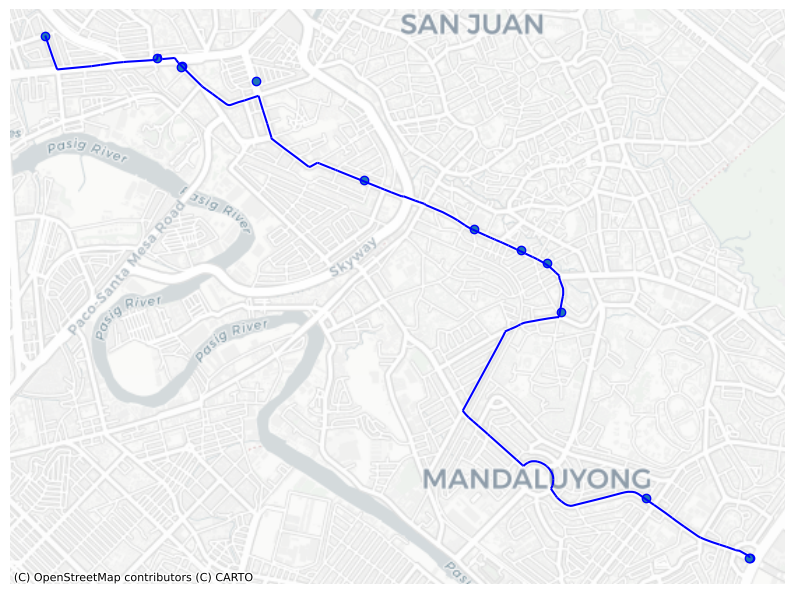

In [147]:
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

In [44]:
# Initialize the OSM API client
api = OsmApi()

# Specify the relation ID
relation_id = 11246072  # Replace with your actual relation ID

# Retrieve the relation by its ID
relation = api.RelationGet(relation_id)

In [58]:
# Create containers for nodes and ways
nodes = {}
ways = {}

# Iterate over relation members to retrieve details
for member in relation['member']:
    if member['type'] == 'node':
        # Get the node data by ID
        node = api.NodeGet(member['ref'])
        nodes[node['id']] = (node['lat'], node['lon'])  # Store lat/lon

    elif member['type'] == 'way':
        # Get the way data by ID
        way = api.WayGet(member['ref'])
        ways[way['id']] = way['nd']  # Store the node references for the way

In [ ]:
# Convert nodes to Points
node_points = {node_id: Point(lon, lat) for node_id, (lat, lon) in nodes.items()}

In [83]:
# Convert ways to LineStrings
way_lines = {}
for way_id, node_ids in ways.items():
    way_points_raw = [api.NodeGet(node_id) for node_id in node_ids]
    way_points = [Point(node['lon'], node['lat']) for node in way_points_raw]
    if len(way_points) > 1:
        way_lines[way_id] = LineString(way_points)

In [55]:
# Create a GeoDataFrame for nodes
gdf_node_points = gpd.GeoDataFrame(
    {'id': list(node_points.keys()), 'geometry': list(node_points.values())},
    crs="EPSG:4326"  # WGS84
)

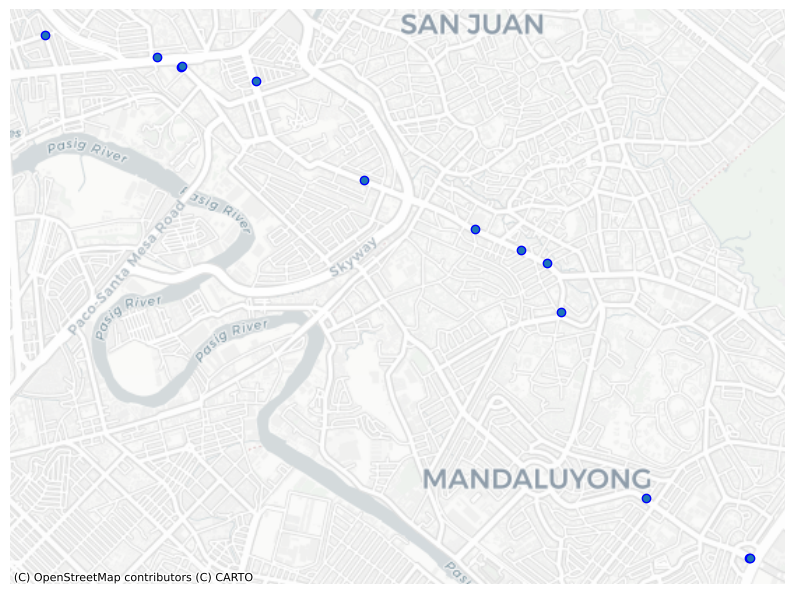

In [56]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm = gdf_node_points.to_crs(epsg=3857)
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

In [84]:
# Create a GeoDataFrame for ways
gdf_way_points = gpd.GeoSeries(pd.Series(way_lines.values()), 
    crs="EPSG:4326"  # WGS84
)

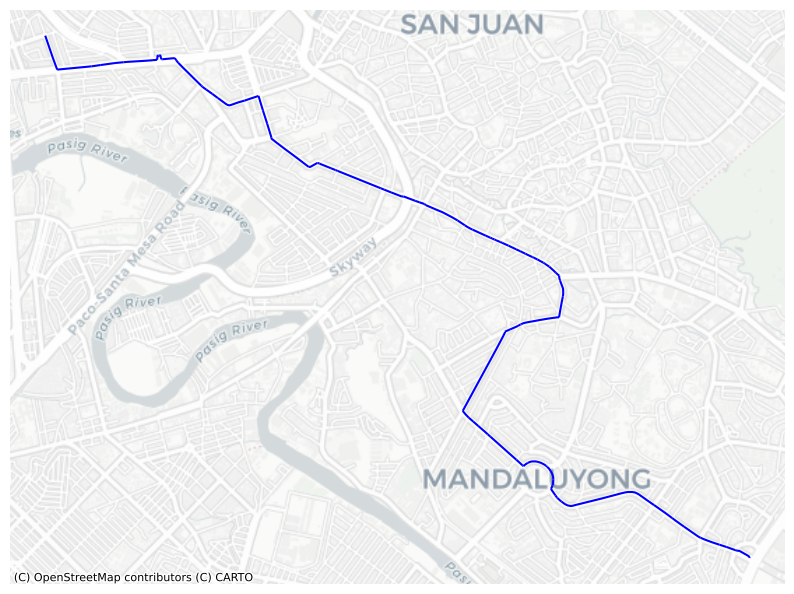

In [87]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_ways_wm = gdf_way_points.to_crs(epsg=3857)
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Now, let's overlay the nodes and way lines together.

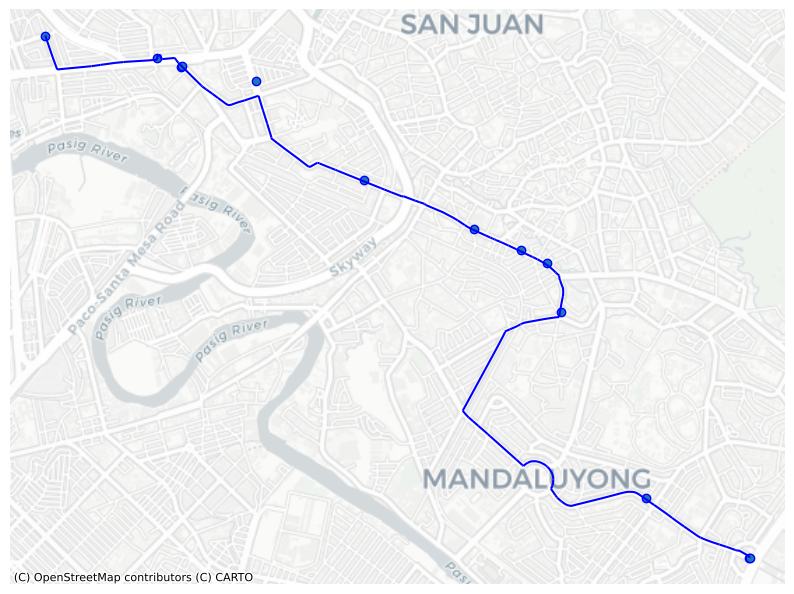

In [88]:
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

# Conclusion